In [178]:
'''
4. What percentage of projects include views from DACs.
'''
import json, re, ast
import numpy as np
import pandas as pd
%matplotlib inline
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from operator import itemgetter
from collections import OrderedDict
from jupyterthemes import jtplot
from numpy.polynomial import Polynomial
import pygal

# you can select an alternative theme's plot style by name
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
# set "context" (paper, notebook, talk, or poster)
# & font scale (scalar applied to labels, legend, etc.)
jtplot.style('monokai', context='notebook', fscale=1.4)

# turn on X- and Y-axis tick marks (default=False)
# and turn off the axis grid lines (default=True)
jtplot.style(ticks=True)

# set the default figure size
# x (length), y (height)
jtplot.figsize(x=20, y=20)

# or just adjust the aspect ratio
# new_length = length * aspect
# jtplot.figsize(aspect=1.5)

# # fully reset matplotlib default rcParams
# jtplot.reset()

In [179]:
outreach_col = 'Stakeholder Outreach and Involvement'
budget_col = 'Budget'
partners_col = 'Partners'
bio_col = 'Contact'
title_col = 'Title'
description_col = 'Description'
summary = 'summary'
description = 'detailed_description'
database = pd.read_excel('./Database.xlsx')
agency_df = "Agency-Dataframe.xlsx"
trans_df = "AnalysisDB.xlsx"

In [180]:
focus_area_colors = {
    'water supply' : '#f44242',
    'wastewater' : '#41f4a9',
    'other' : '#ea04ea',
    'water quality/stormwater': '#208ae8',
    'flood control' : '#3ffff5',
    'natural resources and watersheds' : '#c26dff'
}

markers = {
    'city of cathedral city' : ('>','#f44242'),
    'city of coachella water authority': ('o','#41f4a9'),
    'city of palm springs' : ('v','#c26dff'),
    'coachella valley water district' : ('*','#3ffff5'),
    'college of the desert' : ('s','#3a1f1f'),
    'cvrwmg' : ('8','#c0e509'), 
    'desert empire homes':('d','#08aae5'),
    'desert water agency' : ('h','#64e507'),
    'indio water authority': ('^','#e59b06'),
    'mission springs water district': ('+','#1105e5'),
    'riverside county flood control and water conservation district' : ('H','#e50462'),
    'pueblo unido cdc':((5, 2),'#e50404'), 
    'riverside county, supervisor benoit':('D','#750a71'),
    'shady lane mobilehome park, inc.':('p','#0a0009'),
    'south mecca group':((5, 0),'#e8ff84'),
    'the esperanza youth and family center':('x', '#42e5cd'),
    'torres martinez dci':((5, 1), '#1a4942'),
    'tribal government':('<','#3c1948')
}

def median(lst):
    return np.median(np.array(lst))

def visualize_agencies():
    df = pd.read_excel(agency_df)
    cols = [col for col in df.columns]
    rows = [row for row in df.index]
    
    volume = {}
    medians = {}
    for agency in cols:
        focus_areas = {}
        budget = sorted([float(x.replace(',', '')) for x in 
                         ast.literal_eval(df[agency][rows[0]])])
        print budget
        medians[agency] = median(budget)
        volume[agency] = int(df[agency][rows[2]])
        areas = ast.literal_eval(df[agency][rows[1]])

        for x in areas:
            if x in focus_areas:
                 focus_areas[x] += 1 
            else: focus_areas[x] = 1 
                
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(18.5, 10.5)
        plt.suptitle(agency)
        
        print focus_areas.keys()
        colors = [focus_area_colors[c.replace(',', '').lower()] for c in focus_areas.keys()]
        ax[0].bar(range(len(focus_areas)), focus_areas.values(), color=colors)
        ax[0].set_title('Focus Areas')
        
        ax[1].bar(range(len(budget)), budget)
        ax[1].set_title('Project Size')
        plt.show()
    
    print 'Statistics.'
    print '-----------'
    for each in medians:
        print each, '------------------', medians[each], volume[each]
# visualize_agencies()

In [181]:
''' 
{
    agency_name : { 
            num_projects : num, 
            budgets : [p_1, p_2, p_3, ...],
            partners : [partner_1, partner_2, ....],
            functional_areas: [area_1, area_2, ...],
            agency_type : code
        }
}
'''
def append_zero(ls_ls):
    for ls in ls_ls:
        ls.append(0)
        
        
def clean_agency(agency):
    agency = agency.lower()
    if  agency == u'cvwd':
        agency = u'coachella valley water district'
    elif agency == u'rcfc&wcd':
        agency = 'riverside county flood control and water conservation district'
    elif agency == u'coachella water authority':
        agency = 'city of coachella water authority'
    elif agency == u'pueblo unido':
        agency = 'pueblo unido cdc'
    elif agency == u'cvwd':
        agency = 'coachella valley water district'
    elif agency == 'palm springs':
        agency = 'city of palm springs'
    elif agency == u'riverside county, supervisor benoit':
        agency = u'riverside county'
    return agency  
        
def explore_agencies(agencies, budgets, partners, func_areas, titles):
    num_projects_dict = {}
    tf = {'Title' : titles, 'Sponsor Agency' : agencies, 'Requested Amount' : budgets,
            'Partner Agencies' : partners}
    
    water_supply = []
    wastewater  = []
    other = []
    water_quality = []
    flood_ctrl = []
    natural_water = []
    for idx, area in enumerate(func_areas):
        area = area.replace(',', '').strip()
        
        if area == 'water supply':
            water_supply.append(1)
            append_zero([other, wastewater, water_quality, flood_ctrl, natural_water])
        elif area == 'wastewater':
            wastewater.append(1)
            append_zero([other, water_supply, water_quality, flood_ctrl, natural_water])
        elif area == 'other':
            other.append(1)
            append_zero([water_supply, wastewater, water_quality, flood_ctrl, natural_water])
        elif area == 'water quality/stormwater':
            water_quality.append(1)
            append_zero([other, wastewater, water_supply, flood_ctrl, natural_water])
        elif area == 'flood control':
            flood_ctrl.append(1)
            append_zero([other, wastewater, water_quality, natural_water, water_supply])
        else:
            natural_water.append(1)
            append_zero([other, wastewater, water_quality, flood_ctrl, water_supply])
    
    tf['Water Supply'] = water_supply; tf['Water Water'] = wastewater
    tf['Other'] = other; tf['Water Quality/StormWater'] = water_quality
    tf['Flood Control'] = flood_ctrl
    tf['Natural Resources and Watersheds'] = natural_water
    
    tf_df = pd.DataFrame(tf)
    tf_df.to_excel(trans_df)
    
    for idx, agency in enumerate(agencies):
        agency = clean_agency(agency)     
        cur_budget = budgets[idx].replace('$', '').strip()
        cur_partners = [x for x in partners[idx] if len(x.strip()) > 0]
        
        if agency in num_projects_dict:
            cur = num_projects_dict[agency]
            cur['num_projects'] += 1
            cur['budgets'].append(cur_budget)
            cur['partners'] += cur_partners
            cur['func_areas'].append(func_areas[idx])
        else:
            num_projects_dict[agency] = {
                'num_projects' : 1,
                'budgets'      : [cur_budget],
                'partners'     : cur_partners,
                'func_areas'   : [func_areas[idx]]
            }
            
    df = pd.DataFrame(num_projects_dict)
    df.to_excel(agency_df)

def explore_project():
    titles = database[title_col]
    budget = [json.loads(x)['cost'].strip() for x in database[budget_col]]
    agencies = [json.loads(x)['agency'].strip().lower() for x in database[bio_col]]
    partners = [re.split(",|;| and ", x.strip()) for x in database[partners_col]]
    descriptions = [json.loads(x)[summary] + " " + json.loads(x)[description] 
                    for x in database[description_col]]
    func_areas = [json.loads(x)["primary_functional_area"].strip().lower() for x in database['Type']]
    explore_agencies(agencies, budget, partners, func_areas, titles)
    
# explore_project()

In [182]:
def format_plt(plt, ax1, data, color):
    bp = plt.boxplot(data, 0, sym='')
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['fliers'], color=color)
#     ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
#                    alpha=0.5)
    
def make_scatter(df_1, df_2):
    budget_by_agency_type = {}
    for agency in df_1.columns:
        b = [float(x.replace(',', '')) for x in ast.literal_eval(df_1[agency]['budgets'])]
        t = df_1[agency]['Code']
        if t in budget_by_agency_type:
            budget_by_agency_type[t] += b
        else:
            budget_by_agency_type[t] = b
            
    for k, v in budget_by_agency_type.iteritems():
        m = np.median(v)
        b = [m if x < 10000 else x for x in v]
        budget_by_agency_type[k] = b
        
    data = budget_by_agency_type.values()
    names = budget_by_agency_type.keys()
    
    fig, ax1 = plt.subplots()
    fig.canvas.set_window_title('Project Sizes by Sponsor Agency Type')
#     plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
    
    format_plt(plt, ax1, data, '#04f488')

    # Hide these grid behind plot objects
    ax1.set_axisbelow(True)
    ax1.set_title('Project Sizes by Sponsor Agency Type')
    ax1.set_xlabel('Agency Type')
    ax1.set_ylabel('Requested Amount/ 10, 000')
    plt.xticks([x+1 for x in xrange(len(names))], names, rotation = 'vertical')
    plt.show()

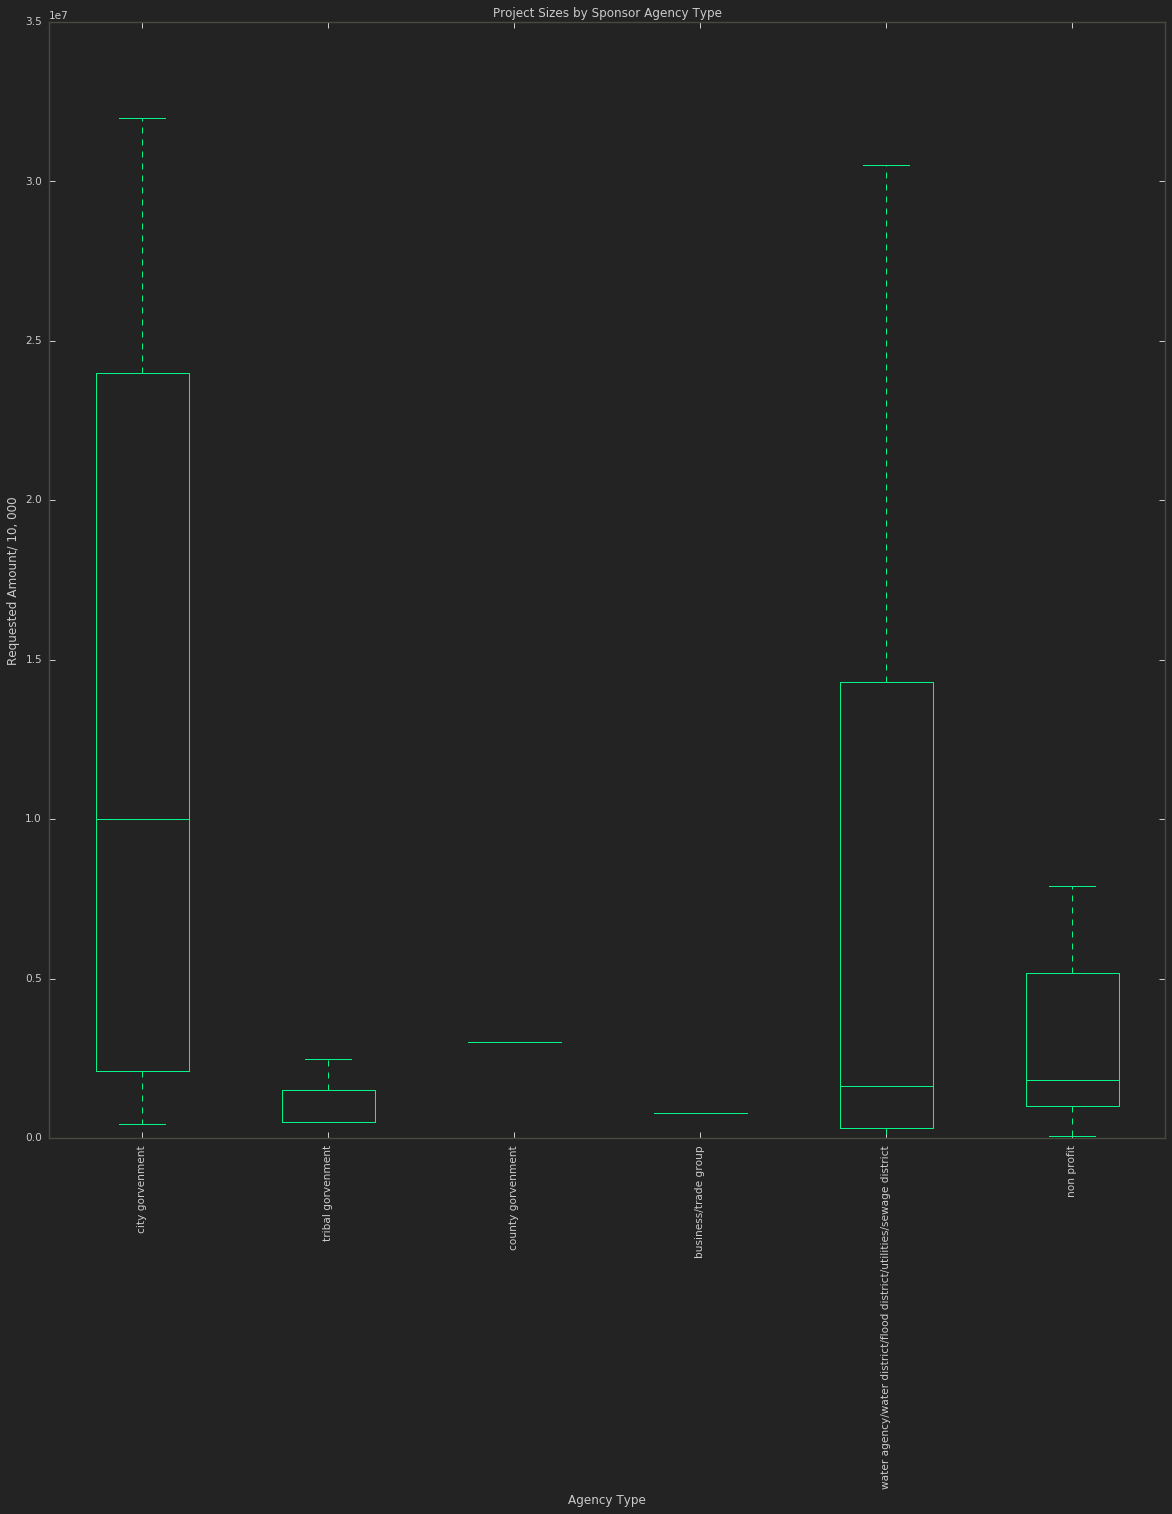

In [183]:
df_1 = pd.read_excel(agency_df)
df_2 = pd.read_excel(trans_df)
make_scatter(df_1, df_2)

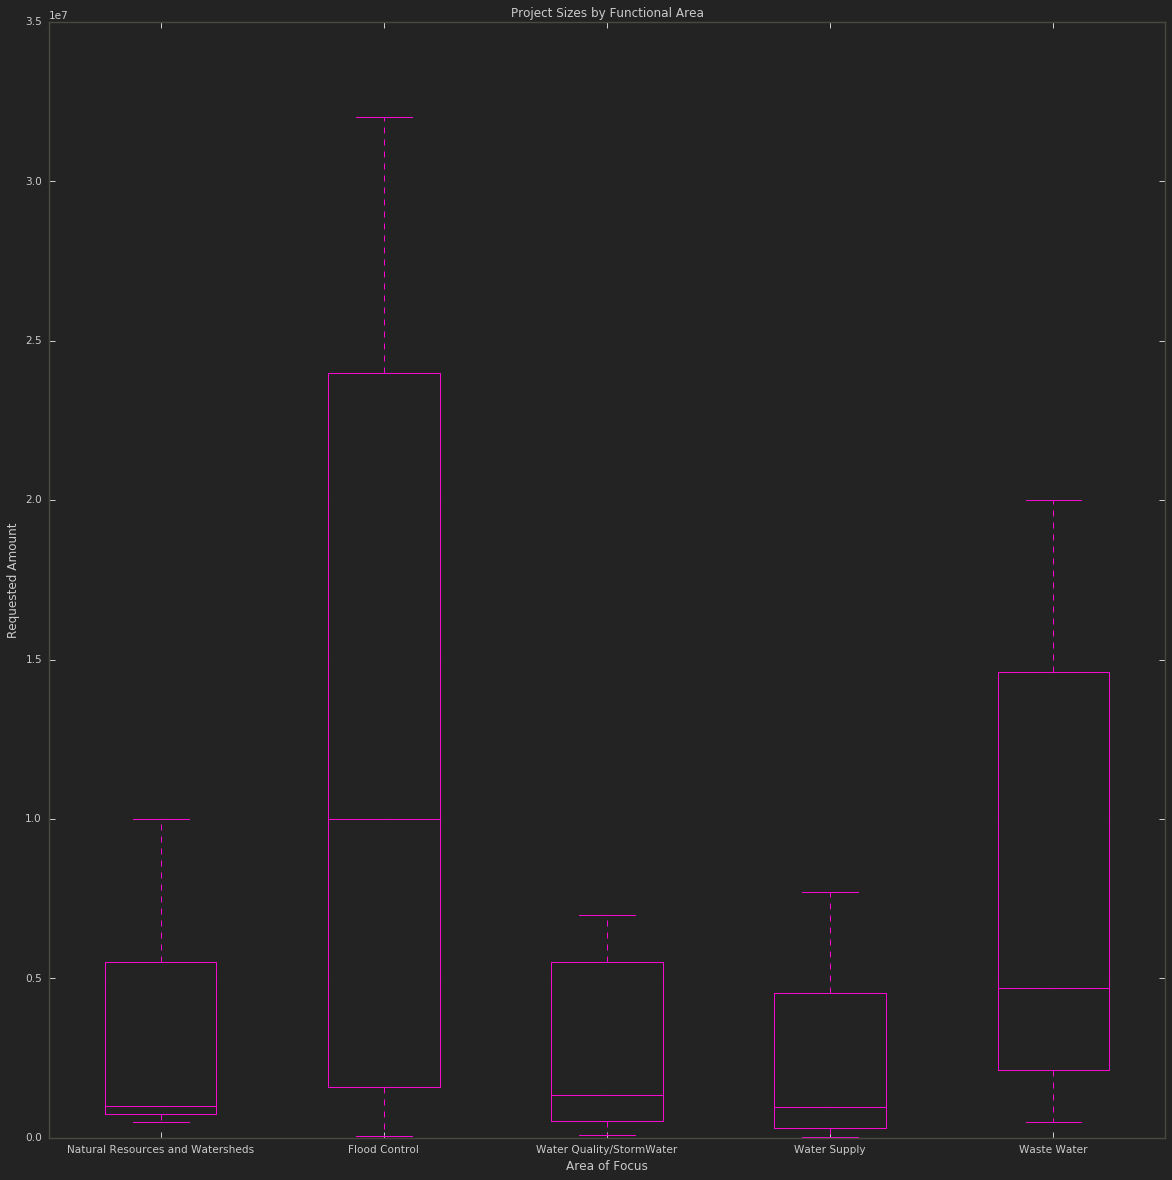

In [184]:
def make_box_p_1(df_1, df_2):
    funding = [float(x.replace(',', '').replace('$', '')) for x in df_2['Requested Amount']]
    areas = ['Natural Resources and Watersheds', 'Flood Control', 'Water Quality/StormWater', 
    'Water Supply', 'Waste Water']
    data = []
    for area in areas:
        fc = [funding[i] for i in xrange(len(funding)) if df_2[area][i] == 1]
        m = np.median(fc)
        fc = [m if x < 10000 else x for x in fc]
        data.append(fc)
    fig, ax1 = plt.subplots()

    format_plt(plt, ax1, data, '#f709cf')
    ax1.set_axisbelow(True)
    ax1.set_title('Project Sizes by Functional Area')
    ax1.set_xlabel('Area of Focus')
    ax1.set_ylabel('Requested Amount')
    plt.xticks([x+1 for x in xrange(len(areas))], areas)
    
    plt.show()
        
make_box_p_1(df_1, df_2)

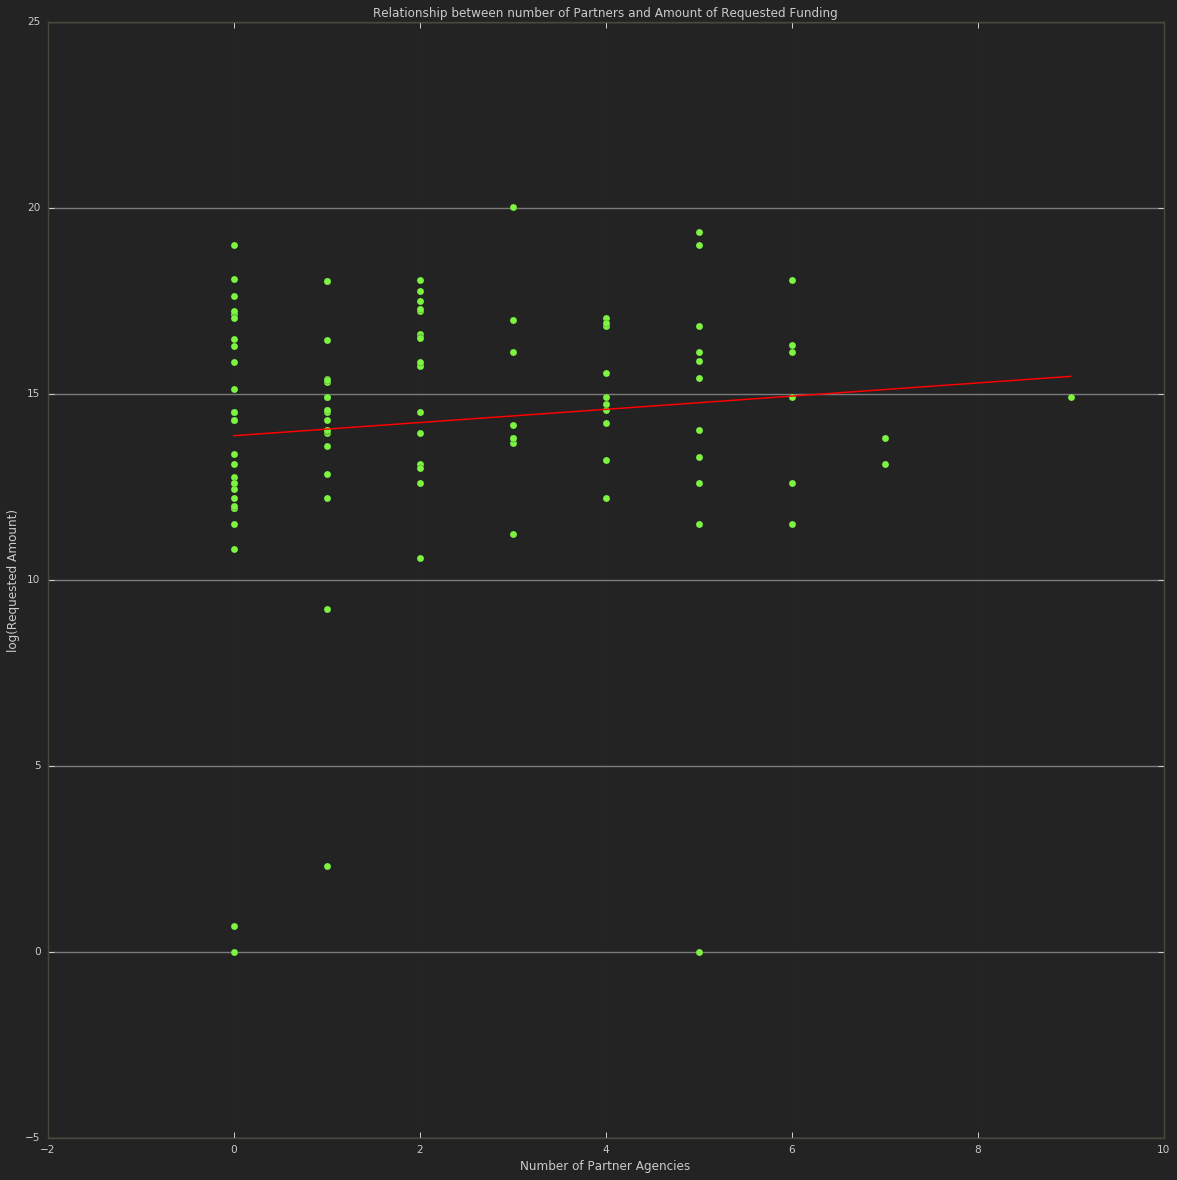

In [193]:
def get_num_partners(df_2):
    num_partners = []
    for x in df_2['Partner Agencies']:
        try:
            num_partners.append(len(ast.literal_eval(x)))
        except:
            num_partners.append(0)
    return num_partners
    
def make_hist_1(df_1, df_2):
    funding = [math.log(float(x.replace(',', '').replace('$', '')))for x in df_2['Requested Amount']]
    num_partners = get_num_partners(df_2)
    fig, ax1 = plt.subplots()
    
    p = Polynomial.fit(num_partners, funding, 1)
    plt.plot(*p.linspace(), c='red')
    
    plt.scatter(num_partners, funding, s=50, c='#7df442')
    ax1.set_axisbelow(True)
    ax1.set_title('Relationship between number of Partners and Amount of Requested Funding')
    ax1.set_xlabel('Number of Partner Agencies')
    ax1.set_ylabel('log(Requested Amount)')
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)
    plt.show()
    
make_hist_1(df_1, df_2)

6


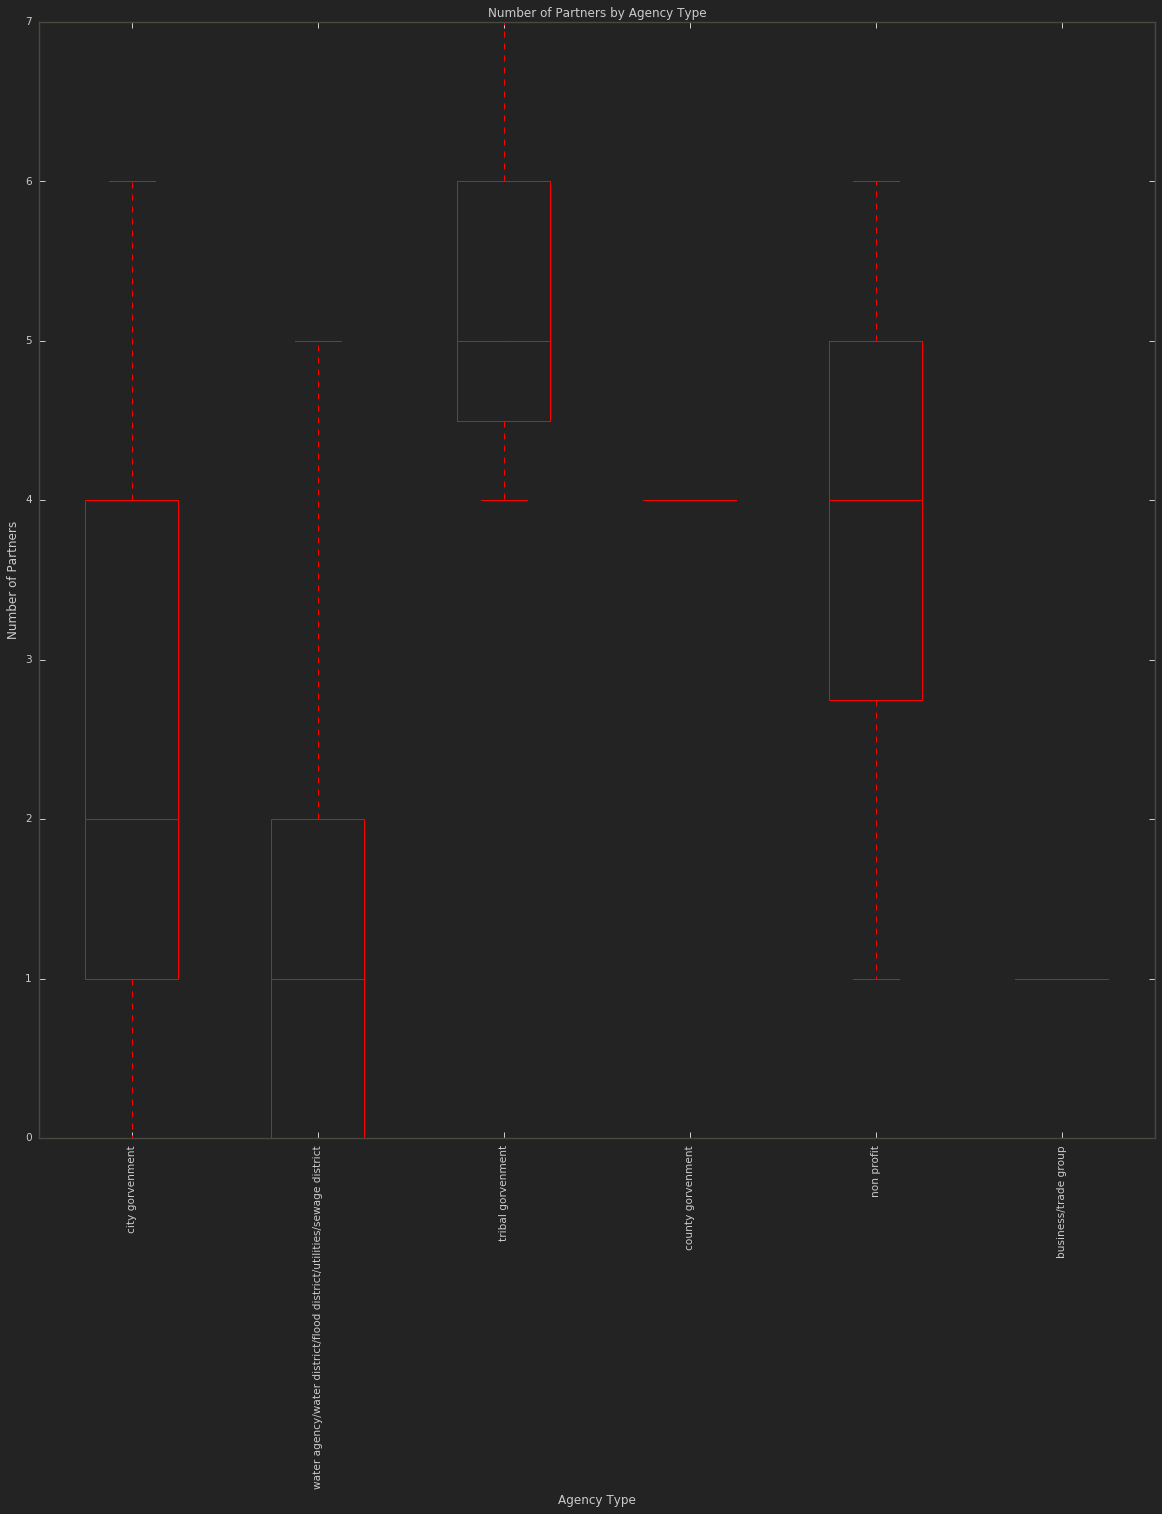

In [186]:
def make_box_p_2(df_1, df_2):
    agencies = [clean_agency(x) for x in df_2['Sponsor Agency']]
    agency_code = [df_1[x]['Code'] for x in agencies]
    num_partners = get_num_partners(df_2)
    data = []
    types = ['city gorvenment', 'water agency/water district/flood district/utilities/sewage district',
            'tribal gorvenment','county gorvenment', 'non profit', 'business/trade group']
    for t in types:
        cur = []
        for i, v in enumerate(agency_code):
            if v == t:
                cur.append(num_partners[i])
        data.append(cur)
    print len(data)
        
    fig, ax1 = plt.subplots()
    format_plt(plt, ax1, data, 'red')
    ax1.set_axisbelow(True)
    ax1.set_title('Number of Partners by Agency Type')
    ax1.set_xlabel('Agency Type')
    ax1.set_ylabel('Number of Partners')
    plt.xticks([x+1 for x in xrange(len(types))], types,  rotation = 'vertical')
    plt.show()
make_box_p_2(df_1, df_2)